In [2]:
import pandas as pd
import pylab as pl 
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
%matplotlib inline

In [3]:
celldf  = pd.read_csv('cell_samples.csv')
celldf.head(10)

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


Distribution of classes based on clump thickness and uniformity of cell size

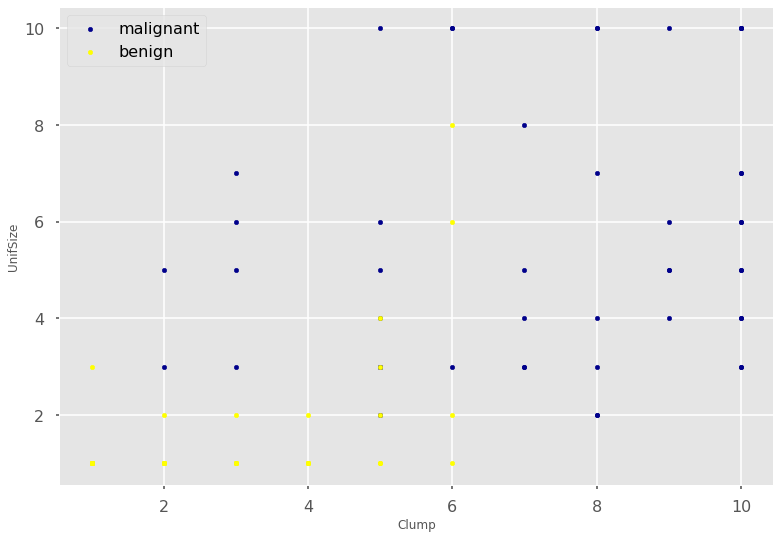

In [4]:
plt.style.use(['seaborn-poster', 'ggplot'])
ax = celldf[celldf['Class'] == 4][0:50].plot(kind = 'scatter', x = 'Clump', y = 'UnifSize', color = 'DarkBlue', label = 'malignant');
celldf[celldf['Class'] == 2][0:50].plot(kind = 'scatter', x = 'Clump', y = 'UnifSize', color = 'Yellow', label = 'benign', ax = ax);
plt.show()

Data pre-processing and selection

In [5]:
celldf.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

In [6]:
# BareNuc includes values that are not numerical, so dropping the rows with non numeric values
celldf = celldf[pd.to_numeric(celldf['BareNuc'], errors = 'coerce').notnull()]
celldf['BareNuc'] = celldf['BareNuc'].astype('int')
celldf.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [8]:
featuredf = celldf[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
x = np.asarray(featuredf)
x[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

Want model to predict value of class (benign = 2, malignant = 4). Need to change measurement level to reflect these two possible values

In [10]:
celldf['Class'] = celldf['Class'].astype('int')
y = np.asarray(celldf['Class'])
y[0:10]

array([2, 2, 2, 2, 2, 4, 2, 2, 2, 2])

Train test split

In [11]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.2, random_state = 4)
print('Train set : ', xTrain.shape, yTrain.shape)
print('Test set : ', xTest.shape, yTest.shape)

Train set :  (546, 9) (546,)
Test set :  (137, 9) (137,)


Mapping data to a higher dimensional space is called kernelling. Can be 

- Linear
- Polynomial
- Radial basis function (RBF)
- Sigmoid

Using the default radial basis function

In [13]:
from sklearn import svm
clf = svm.SVC(kernel = 'rbf')
clf.fit(xTrain, yTrain)
yHat = clf.predict(xTest)
yHat[0:5]

array([2, 4, 2, 4, 2])

Evaluation

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plotConfusionMatrix(cm, classes, normalize = False, title = 'Confusion Matrix', cmap = plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix without normalization')
    
    print(cm)
    
    plt.style.use('seaborn-poster')
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tickMarks = np.arange(len(classes))
    plt.xticks(tickMarks, classes, rotation = 45)
    plt.yticks(tickMarks, classes)
    
    fmt = '.2f' if normalize else 'd'
    threshold = cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = 'center', color = 'white' if cm[i,j] > threshold else 'black')
        
    plt.tight_layout()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

Confusion matrix without normalization
[[85  5]
 [ 0 47]]


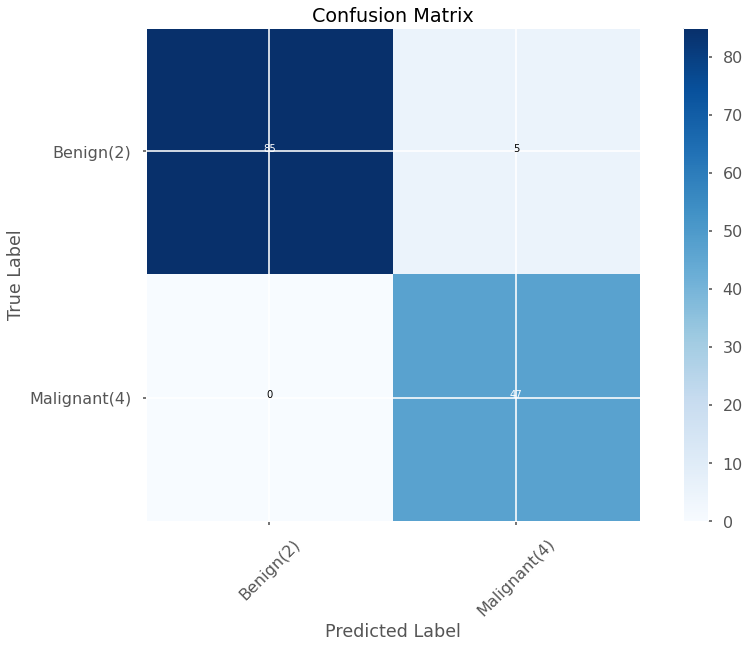

In [24]:
# Computer confusion matrix
cnfMatrix = confusion_matrix(yTest, yHat, labels = [2, 4])
np.set_printoptions(precision = 2)

print(classification_report(yTest, yHat))

# Plot non normalized confusion matrix
plt.style.use('seaborn-poster')
plt.figure()
plotConfusionMatrix(cnfMatrix, classes = ['Benign(2)', 'Malignant(4)'], normalize = False, title = 'Confusion Matrix')

Using Linear kernelling

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

Confusion matrix without normalization
[[85  5]
 [ 0 47]]


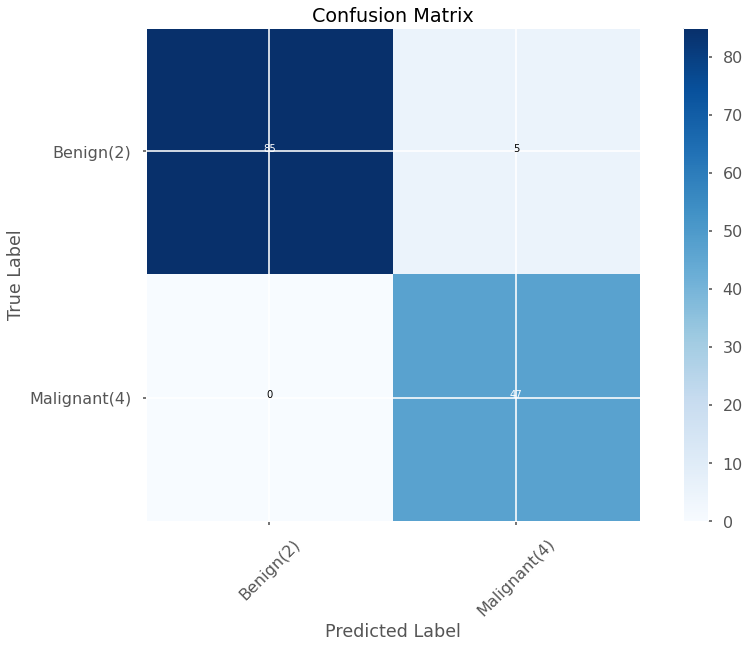

In [26]:
clf = svm.SVC(kernel = 'linear')
clf.fit(xTrain, yTrain)
yHat = clf.predict(xTest)

cnfMatrix = confusion_matrix(yTest, yHat, labels = [2, 4])
np.set_printoptions(precision = 2)

print(classification_report(yTest, yHat))

# Plot non normalized confusion matrix
plt.style.use('seaborn-poster')
plt.figure()
plotConfusionMatrix(cnfMatrix, classes = ['Benign(2)', 'Malignant(4)'], normalize = False, title = 'Confusion Matrix')